<a href="https://colab.research.google.com/github/ARPRAHMAN/AI_Problems/blob/main/LabFinal_6168.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os, time, math, random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

In [17]:
# ---------------------- Config (change if you want) ----------------------
P_COLAB = "/content/drive/MyDrive/AI_dataset/Distances.csv"
symmetrize_method = "min"    # "min", "mean", or None
k_nn = 3                     # neighbors for knowledge-graph k-NN
sample_size = 20             # number of rows for the knowledge-graph sample
longest_path_limit_nodes = 20
pair_timeout = 1.0           # seconds per pair when approximating longest simple paths

In [18]:
df_raw = pd.read_csv(P_COLAB)

In [19]:
# ---------------------- 1) Preprocess: set index + numeric coercion + diagonal + symmetrize ----------------------
df = df_raw.copy()
# Use the first column as index (city names)
df.index = df.iloc[:, 0].astype(str)
df = df.iloc[:, 1:]
df.index.name = None
df.columns = df.columns.astype(str)

# Convert values to numeric (coerce errors to NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Ensure diagonal zero
np.fill_diagonal(df.values, 0.0)

# Symmetrize if requested
if symmetrize_method is not None:
    A = df.values
    if symmetrize_method == "min":
        A_sym = np.minimum(A, A.T)
    elif symmetrize_method == "mean":
        A_sym = (A + A.T) / 2.0
    else:
        A_sym = A
    df = pd.DataFrame(A_sym, index=df.index, columns=df.columns)
    print(f"Symmetrized using: {symmetrize_method}")

# Save cleaned CSV (optional)
clean_path = os.path.splitext(P_COLAB)[0] + "_cleaned.csv"
df.to_csv(clean_path)
print("Saved cleaned CSV to:", clean_path)

# Sanity prints
print("Nodes:", len(df))
print("Any NaN values?:", df.isnull().any().any(), "Total NaNs:", int(df.isnull().sum().sum()))
print("Matrix symmetric?:", np.allclose(df.values, df.values.T, equal_nan=True))
print("Diagonal zeros?:", np.all(np.diag(df.values) == 0.0))

Symmetrized using: min
Saved cleaned CSV to: /content/drive/MyDrive/AI_dataset/Distances_cleaned.csv
Nodes: 50
Any NaN values?: False Total NaNs: 0
Matrix symmetric?: True
Diagonal zeros?: True


In [20]:
# ---------------------- 2) Build adjacency list defensively ----------------------
def build_adjacency_from_distance_df(df, threshold=None, k_nn_local=None):
    nodes = df.index.astype(str).tolist()
    adj = {n: [] for n in nodes}
    for u in nodes:
        row = df.loc[u]
        neighbors = []
        for v in df.columns.astype(str):
            if u == v:
                continue
            # safe access
            try:
                d = row.at[v]
            except Exception:
                continue
            if pd.isna(d) or not np.isfinite(d) or d <= 0:
                continue
            if (threshold is not None) and (d > threshold):
                continue
            neighbors.append((v, float(d)))
        neighbors.sort(key=lambda x: x[1])
        if k_nn_local is not None and len(neighbors) > k_nn_local:
            neighbors = neighbors[:k_nn_local]
        adj[u] = neighbors
    return adj

# Build full adjacency (no threshold, no k-NN) for DFS/traversal
adjacency_full = build_adjacency_from_distance_df(df, threshold=None, k_nn_local=None)
print("Built adjacency. Example neighbor counts (first 5 nodes):")
for n in list(adjacency_full.keys())[:5]:
    print(" ", n, "->", len(adjacency_full[n]))


Built adjacency. Example neighbor counts (first 5 nodes):
  Kolapur -> 49
  Ahmedabad -> 49
  Vellore -> 49
  Agra -> 49
  Cuttack -> 49


In [21]:
# ---------------------- 3) DFS implementations (AI_W3 style) ----------------------
def dfs_recursive(start, adj):
    visited = set()
    order = []
    parent = {start: None}
    def visit(u):
        visited.add(u)
        order.append(u)
        for v, _ in adj.get(u, []):
            if v not in visited:
                parent[v] = u
                visit(v)
    visit(start)
    return order, parent

def dfs_iterative(start, adj):
    visited = set([start])
    stack = [start]
    order = []
    parent = {start: None}
    while stack:
        u = stack.pop()
        order.append(u)
        for v, _ in reversed(adj.get(u, [])):
            if v not in visited:
                visited.add(v)
                parent[v] = u
                stack.append(v)
    return order, parent

start_node = df.index.astype(str).tolist()[0]
rec_order, rec_parent = dfs_recursive(start_node, adjacency_full)
it_order, it_parent = dfs_iterative(start_node, adjacency_full)
print(f"DFS from {start_node}: recursive visited {len(rec_order)} nodes, iterative visited {len(it_order)} nodes")
print("First 10 (recursive):", rec_order[:10])
print("First 10 (iterative):", it_order[:10])


DFS from Kolapur: recursive visited 50 nodes, iterative visited 50 nodes
First 10 (recursive): ['Kolapur', 'Gandhinagar', 'Ahmedabad', 'Vadodara', 'Rajkot', 'Dwarka', 'Mumbai', 'Pune', 'Nashik', 'Aurangabad']
First 10 (iterative): ['Kolapur', 'Gandhinagar', 'Ahmedabad', 'Rajkot', 'Vadodara', 'Jodhpur', 'Dwarka', 'Jaisalmer', 'Indore', 'Kota']


Feature projection (first 5 rows):
                PC1       PC2       PC3
Kolapur   -4.474213  3.268099 -0.173699
Ahmedabad -4.410600  3.249670 -1.165843
Vellore    5.603271  3.892818 -1.550052
Agra      -5.612773 -0.947934  0.777985
Cuttack    3.562034 -5.303243 -1.053281
Knowledge graph nodes: 20 edges: 39


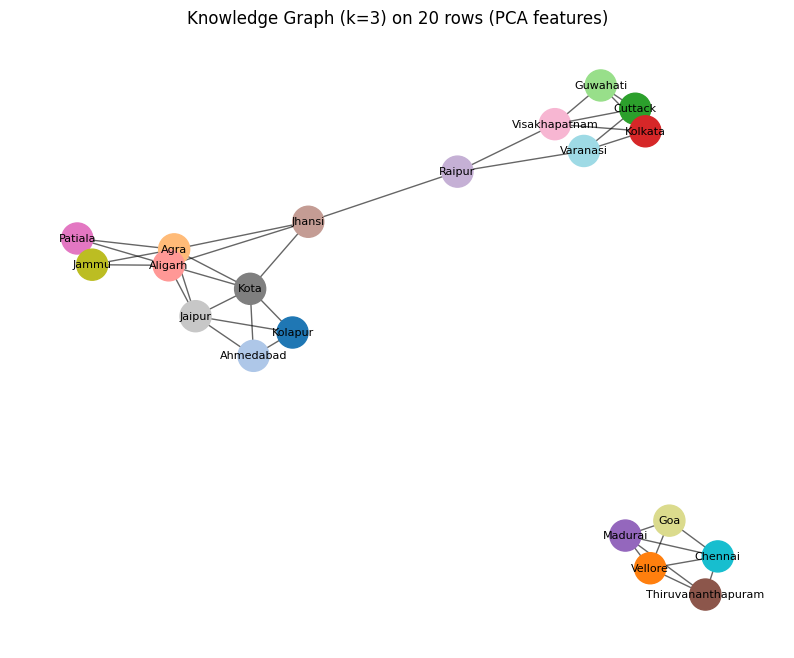

In [22]:
# ---------------------- 4) Knowledge graph on a 20-row sample ----------------------
# 4.1 choose sample rows (first sample_size rows)
if sample_size > len(df):
    sample_size = len(df)
sample_df = df.iloc[:sample_size].copy()
sample_nodes = sample_df.index.astype(str).tolist()

# 4.2 create 3 features via PCA on row vectors (rows = city's distances to all cities)
scaler = StandardScaler()
rows_scaled = scaler.fit_transform(sample_df.values)   # may be (sample_size, n_cols)
pca = PCA(n_components=3, random_state=0)
features3 = pca.fit_transform(rows_scaled)
feat_df = pd.DataFrame(features3, index=sample_nodes, columns=["PC1","PC2","PC3"])
print("Feature projection (first 5 rows):")
print(feat_df.head())

# 4.3 build k-NN graph on these features
D_feat = squareform(pdist(features3, metric="euclidean"))
G = nx.Graph()
for i,u in enumerate(sample_nodes):
    G.add_node(u, label=u, idx=i)
for i,u in enumerate(sample_nodes):
    neigh_idx = np.argsort(D_feat[i])[1:k_nn+1]
    for j in neigh_idx:
        v = sample_nodes[int(j)]
        if not G.has_edge(u,v):
            G.add_edge(u, v, weight=float(D_feat[i,j]))
print("Knowledge graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# 4.4 matplotlib visualization
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42, k=0.5)
node_colors = list(range(len(sample_nodes)))
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, cmap=plt.cm.tab20)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title(f"Knowledge Graph (k={k_nn}) on {sample_size} rows (PCA features)")
plt.axis('off')
plt.show()

# 4.5 optional interactive Plotly visualization
if PLOTLY_AVAILABLE:
    edge_x, edge_y = [], []
    for u,v in G.edges():
        x0,y0 = pos[u]; x1,y1 = pos[v]
        edge_x += [x0,x1,None]; edge_y += [y0,y1,None]
    edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1,color='rgba(120,120,120,0.6)'))
    node_x, node_y, node_text = [], [], []
    for n in G.nodes():
        x,y = pos[n]; node_x.append(x); node_y.append(y)
        node_text.append(f"{n}<br>PC1={feat_df.loc[n,'PC1']:.3f} PC2={feat_df.loc[n,'PC2']:.3f}")
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers+text', text=[n for n in G.nodes()], textposition="top center",
                            marker=dict(size=18))
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(title=f"Interactive Knowledge Graph (k={k_nn})", showlegend=False, width=900, height=700)
    fig.show()
else:
    print("Plotly not available — interactive visualization skipped.")


In [23]:
# ---------------------- 5) Shortest path (Dijkstra) vs 'longest simple path' approx ----------------------
def all_pairs_shortest_paths(G, weight="weight"):
    pairs = {}
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        u = nodes[i]
        lengths = nx.single_source_dijkstra_path_length(G, u, weight=weight)
        for j in range(i+1, len(nodes)):
            v = nodes[j]
            pairs[(u,v)] = float(lengths[v]) if v in lengths else float('inf')
    return pairs

sp_pairs = all_pairs_shortest_paths(G, weight="weight")
print("Computed shortest-path lengths for sample graph pairs:", len(sp_pairs))

# long simple path approximation (DFS enumeration with time cap per pair)
def longest_simple_path_length(G, source, target, timeout_seconds=1.0):
    t0 = time.time()
    best = -float("inf")
    visited = set()
    def dfs(u, cum):
        nonlocal best
        if time.time() - t0 > timeout_seconds:
            return
        if u == target:
            if cum > best:
                best = cum
        for v in G.neighbors(u):
            if v not in visited:
                w = G[u][v].get("weight",1.0)
                visited.add(v)
                dfs(v, cum + float(w))
                visited.remove(v)
                if time.time() - t0 > timeout_seconds:
                    return
    visited.add(source)
    dfs(source, 0.0)
    return best

longest_pairs = {}
for (u,v), sp_len in sp_pairs.items():
    if not nx.has_path(G, u, v):
        longest_pairs[(u,v)] = float('-inf')
        continue
    if len(G.nodes()) <= longest_path_limit_nodes:
        longest_pairs[(u,v)] = longest_simple_path_length(G, u, v, timeout_seconds=pair_timeout)
    else:
        longest_pairs[(u,v)] = float('nan')

# Build DataFrame summarizing pair metrics
rows = []
for (u,v), sp_len in sp_pairs.items():
    # direct distance from cleaned df (if present)
    direct = float(df.loc[u, v]) if (u in df.index and v in df.columns and not pd.isna(df.loc[u,v])) else float('nan')
    lp = longest_pairs.get((u,v), float('nan'))
    rows.append({"u":u,"v":v,"direct_distance":direct,"shortest_path":sp_len,"longest_simple_path_approx":lp})
df_pairs = pd.DataFrame(rows)
print("Pairs summary head:")
print(df_pairs.head())

# correlations
def safe_corr(a,b):
    a = np.array(a, dtype=float); b = np.array(b, dtype=float)
    mask = (~np.isinf(a)) & (~np.isinf(b)) & (~np.isnan(a)) & (~np.isnan(b))
    if mask.sum() < 3:
        return float('nan')
    return float(pd.Series(a[mask]).corr(pd.Series(b[mask])))

corr_direct_sp = safe_corr(df_pairs["direct_distance"].values, df_pairs["shortest_path"].values)
corr_sp_lp = safe_corr(df_pairs["shortest_path"].values, df_pairs["longest_simple_path_approx"].values)
print(f"Correlation direct_distance vs shortest_path = {corr_direct_sp:.4f}")
print(f"Correlation shortest_path vs longest_simple_path_approx = {corr_sp_lp:.4f}")


Computed shortest-path lengths for sample graph pairs: 190
Pairs summary head:
         u          v  direct_distance  shortest_path  \
0  Kolapur  Ahmedabad          137.513       0.994352   
1  Kolapur    Vellore       100000.000            inf   
2  Kolapur       Agra          737.237       4.851902   
3  Kolapur    Cuttack       100000.000      18.256243   
4  Kolapur   Guwahati       100000.000      20.501087   

   longest_simple_path_approx  
0                   26.618615  
1                        -inf  
2                   26.925137  
3                   57.066947  
4                   56.487344  
Correlation direct_distance vs shortest_path = 0.8261
Correlation shortest_path vs longest_simple_path_approx = 0.8759


In [24]:
# ---------------------- 6) Complexity notes & summary ----------------------
print("\nTime complexity notes:")
print("- Building adjacency (naive): O(n^2)")
print("- DFS: O(n + m) (dense graphs -> ~O(n^2))")
print("- PCA on sample rows: O(s * d * k) roughly")
print("- k-NN building (dense): O(s^2)")
print("- All-pairs Dijkstra (naive via single-source repeated): O(s * (m log n))")
print("- Longest simple path exact search: exponential (we used time-limited brute force)")

summary = {
    "cleaned_csv": clean_path,
    "n_nodes_total": len(df),
    "sample_size": sample_size,
    "kg_nodes": G.number_of_nodes(),
    "kg_edges": G.number_of_edges(),
    "corr_direct_vs_sp": corr_direct_sp,
    "corr_sp_vs_lp": corr_sp_lp
}
print("\nSummary:", summary)



Time complexity notes:
- Building adjacency (naive): O(n^2)
- DFS: O(n + m) (dense graphs -> ~O(n^2))
- PCA on sample rows: O(s * d * k) roughly
- k-NN building (dense): O(s^2)
- All-pairs Dijkstra (naive via single-source repeated): O(s * (m log n))
- Longest simple path exact search: exponential (we used time-limited brute force)

Summary: {'cleaned_csv': '/content/drive/MyDrive/AI_dataset/Distances_cleaned.csv', 'n_nodes_total': 50, 'sample_size': 20, 'kg_nodes': 20, 'kg_edges': 39, 'corr_direct_vs_sp': 0.8261445542618953, 'corr_sp_vs_lp': 0.8759343041452546}
